In [1]:
# Install the necessary dependencies

import os
import sys 
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Autoencoder

## Overview

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. The autoencoder learns an efficient representation (encoding) for a set of data, typically for dimensionality reduction.

## Unsupervised Learning

Autoencoder is a kind of unsupervised learning, which means working with datasets without considering a target variable. There are some Applications and Goals for it:

- Finding hidden structures in data.
- Data compression.
- Clustering.
- Retrieving similar objects.
- Exploratory data analysis.
- Generating new examples.

And for unsupervised learning, its main Principal Component Analysis (PCA) is:

- Find directions of maximum variance

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/01_PCA1.png
---
name: Illustration of PCA 1
---
PCA 1
:::

- Transform features onto directions of maximum variance

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/02_PCA2.png
---
name: Illustration of PCA 2
---
PCA 2
:::

- Usually consider a subset of vectors of most variance (dimensionality reduction)

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/03_PCA3.png
---
name: Illustration of PCA 3
---
PCA 3
:::

## Fully-connected Autoencoder

Here is an example of a basic fully-connected autoencoder

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/04_simple.png
---
name: Illustration of Fully Connected autoencoder
---
Simple
:::

:::{note}
If we don't use non-linear activation functions and minimize the MSE, this is very similar to PCA. However, the latent dimensions will not necessarily be orthogonal and will have same variance.
:::

The loss function of this simple model is 
$$L(x, x') = \left\lVert x - x' \right\rVert^2_2 = \sum_i (x_i - x_i')^2$$


### Potential Autoencoder Applications

And there are some potential autoencoder applications, for example:
- After training, disregard the output part, we can use embedding as input to classic machine learning methods (SVM, KNN, Random Forest, ...).
- Similar to transfer learning, we can train autoencoder on large image dataset, then fine tune encoder part on your own, smaller dataset and/or provide your own output (classification) layer.
- Latent space can also be used for visualization (EDA, clustering), but there are better methods for that.

## Convolutional Autoencoder

For convolutional autoencoder, we mainly use transposed convolution construct the output, and transposed convolution (sometimes called "deconvolution") allows us to increase the size of the output feature map compared to the input feature map.

The difference between regular convolution and transposed convolution can be seen from the following image.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/05_diff_conv.png
---
name: Difference between regular and transposed convolution
---
diff
:::

In transposed convolutions, we stride over the output; hence, larger strides will result in larger outputs (opposite to regular convolutions); and we pad the output; hence, larger padding will result in smaller output maps.

So, the whole model consists of two parts, encoder and decoder, and they are composed with regular convolution and transposed convolution respectively.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/autoencoder/06_convmodel.png
---
name: Structure of convoluted autoencoder
---
Structure
:::

:::{note}
Here is some other tricks to help our training:
1. Add dropout layers to force networks to learn redundant features.
2. Add dropout after the input, or add noise to the input to learn to denoise images.
3. Add L1 penalty to the loss to learn sparse feature representations.
:::

## Code

Let's build a 2-layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them. And this project will be done on MNIST dataste.

In [2]:
import tensorflow as tf
import numpy as np

MNIST Dataset parameters.

In [3]:
num_features = 784 # data features (img shape: 28*28).

Training parameters.

In [4]:
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

Network Parameters

In [5]:
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

Prepare MNIST data.

In [6]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

Use tf.data API to shuffle and batch data.

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

Store layers weight & bias.
A random value generator to initialize weights.

In [8]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features])),
}

C:\Users\Victor\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Building the encoder.

In [9]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

Building the decoder.

In [10]:
def decoder(x):
    # Decoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

Mean square loss between original images and reconstructed ones.

In [11]:
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

Adam optimizer.

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

Optimization process. 

In [13]:
def run_optimization(x):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())
    
    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

Run training for the given number of steps.

In [14]:
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    # Run the optimization.
    loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))

step: 0, loss: 0.234978
step: 1000, loss: 0.016520
step: 2000, loss: 0.010679
step: 3000, loss: 0.008460
step: 4000, loss: 0.007236
step: 5000, loss: 0.006323
step: 6000, loss: 0.006220
step: 7000, loss: 0.005524
step: 8000, loss: 0.005355
step: 9000, loss: 0.005005
step: 10000, loss: 0.004884
step: 11000, loss: 0.004767
step: 12000, loss: 0.004663
step: 13000, loss: 0.004198
step: 14000, loss: 0.004016
step: 15000, loss: 0.003990
step: 16000, loss: 0.004066
step: 17000, loss: 0.004013
step: 18000, loss: 0.003900
step: 19000, loss: 0.003652
step: 20000, loss: 0.003604


Testing and Visualization.

In [15]:
import matplotlib.pyplot as plt

Encode and decode images from test set and visualize their reconstruction.

Original Images


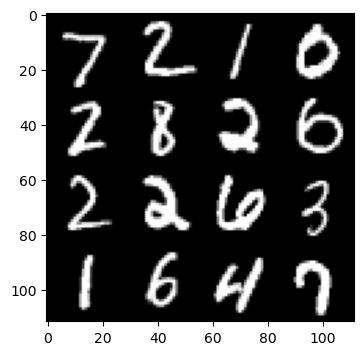

Reconstructed Images


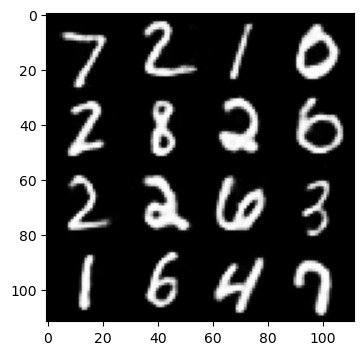

In [16]:
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

## Your turn! 🚀

TBD.

## Self study

You can refer to this book chapter for further study:

- [deeplearningbook](https://www.deeplearningbook.org/contents/autoencoders.html)

## Acknowledgments

Thanks to [Sebastian Raschka](https://github.com/rasbt) for creating the open-source project [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20) and [Aymeric Damien](https://github.com/aymericdamien) for creating the open-source project [TensorFlow-Examples](https://github.com/aymericdamien/TensorFlow-Examples/). They inspire the majority of the content in this chapter.
